# Twitter Sentiments analysis with an LSTM

## Load Packages

We will use nltk to prepare the data and tensorflow for the model.

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
from nltk.stem import SnowballStemmer


import re
import pickle

import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

print("Tensorflow Version",tf.__version__)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
Tensorflow Version 2.3.0


## Load Data 

In [ ]:
df = pd.read_csv('drive/My Drive/Colab Notebooks/training.1600000.processed.noemoticon.csv',
                 encoding = 'latin-1',header=None)
# Label the columns of our dataset
df.columns = ['sentiment', 'id', 'date', 'query', 'user_id', 'text']
# Drop the columns that we won't need
df = df.drop(['id', 'date', 'query', 'user_id'], axis=1)
# For this example, we are only keeping 3% of the data but ideally
# we will train with the whole dataset if we had the computation power

# Dictionary to replace the numbers to a Binary classification
lab_to_sentiment = {0:"Negative", 4:"Positive"}
def label_decoder(label):
  return lab_to_sentiment[label]

# We replace the sentiment values with our binary classification
df.sentiment = df.sentiment.apply(lambda x: label_decoder(x))

# Print the final data
df.head()

,sentiment,text
0,Negative,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,Negative,is upset that he can't update his Facebook by ...
2,Negative,@Kenichan I dived many times for the ball. Man...
3,Negative,my whole body feels itchy and like its on fire
4,Negative,"@nationwideclass no, it's not behaving at all...."


## Visualize Data

Text(0.5, 1.0, 'Sentiment Data Distribution')

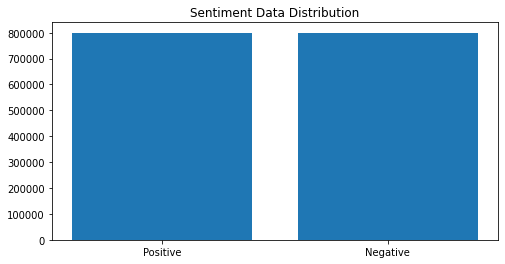

In [ ]:
# Graph of how the dataset is distributed
val_count = df.sentiment.value_counts()
plt.figure(figsize=(8,4))
plt.bar(val_count.index, val_count.values)
plt.title("Sentiment Data Distribution")

## Preprocessing of the data

We process the data to get rid of noisy values + tokenize the words on the tweets correctly

In [ ]:
# We load stop words from nltk corpus
# They are words that are very repetitive and do not add meaning to the text
stop_words = stopwords.words('english')
# Stemmer change the words to their roots
stemmer = SnowballStemmer('english')
# We clean the text from url, that will not provide important information
text_cleaning_re = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"


In [ ]:
# We use a tokenizer focused for Twitter
tknzr = TweetTokenizer()
all_words = []
# Not is removed because it gives important information
# for positive or negative clasification
stop_words.remove('not')

def preprocess(text, stem=False):
  # We get rid of the links on the tweets + lowercase + blank spaces at the end and beginning
  text = re.sub(text_cleaning_re, ' ', str(text).lower()).strip()
  tokens = []
  # The tweets are splited into words
  words = tknzr.tokenize(text)
  # isn´t, ain´t, every word with nt or t is not removed from the tweet
  for token in words:
    if "'t" in token or "'nt" in token:
      token = "not"
      # we get rid of stop_words
    if token not in stop_words:
      if stem:
        # We use steam for every word
        tokens.append(stemmer.stem(token))
      else:
        tokens.append(token)
  return " ".join(tokens)

# we aplly the function that we just create for every row
df.text = df.text.apply(lambda x: preprocess(x))

Separate, tokenize and put into sequences the data

In [ ]:
# 0.8 of the data for train and 0.2 for test
TRAIN_SIZE = 0.8
# Max quantity of words
MAX_NB_WORDS = 100000
# Max sequence length
MAX_SEQUENCE_LENGTH = 50

In [ ]:
# Splits Dataset into Training and Testing set
train_data, test_data = train_test_split(df, test_size=1-TRAIN_SIZE, random_state=0) 
print("Train Data size:", len(train_data))
print("Test Data size", len(test_data))

Train Data size: 1280000
Test Data size 320000


In [ ]:
from keras.preprocessing.text import Tokenizer
# In order to represent word in a way that computer understand
# is used Tokenizer, that encode words with ACSII
tokenizer = Tokenizer(oov_token='<00V>')
tokenizer.fit_on_texts(train_data.text)

# The encoding is saved in a dictionary
# word_index are the words
word_index = tokenizer.word_index
# Quantity of differents words used
vocab_size = len(tokenizer.word_index) + 1
print("Vocabulary Size :", vocab_size)

Vocabulary Size : 287049


In [ ]:
from keras.preprocessing.sequence import pad_sequences

# Now that the words are encoded, it is represented in setences
# Also, the setences are united with a same length (50)
x_train = pad_sequences(tokenizer.texts_to_sequences(train_data.text), padding = 'post', 
                        maxlen = MAX_SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(test_data.text), padding = 'post',
                       maxlen = MAX_SEQUENCE_LENGTH )

print("Training X Shape:",x_train.shape)
print("Testing X Shape:",x_test.shape)

Training X Shape: (1280000, 50)
Testing X Shape: (320000, 50)


In [ ]:
# Differents categories
labels = train_data.sentiment.unique().tolist()
print(labels)

['Positive', 'Negative']


In [ ]:
# Categories are encoded
encoder = LabelEncoder()
encoder.fit(train_data.sentiment.to_list())

# Then, applying this encoding to the data set

y_train = encoder.transform(train_data.sentiment.to_list())
y_test = encoder.transform(test_data.sentiment.to_list())

# We give a form for processing
y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train shape:", y_train.shape)
print(y_train)
print("y_test shape:", y_test.shape)

y_train shape: (1280000, 1)
[[1]
 [1]
 [1]
 ...
 [0]
 [1]
 [0]]
y_test shape: (320000, 1)


## Import a pretrained model for embbeding


In [ ]:
# Embedder represents in vectors the meaning of the words
# it establishes a relationship between words in textual data
# So, similar words will have a similar vector 
# Embedding is a slow processing and requires a lot of training data
# We will use a pre-trained free model: Glove embedder 
# since it exploits the global statistical information regarding word co-concurrences
# It has 300 dimensional word vectors for 400k words

#BB_twtr model

GLOVE_EMB = 'drive/My Drive/Colab Notebooks/glove.6B.300d.txt'

# Embedding dimension
EMBEDDING_DIM = 300
# Learning rate
LR = 0.01
# Size of batch
BATCH_SIZE = 1024
# Quantity of ephocs
EPOCHS = 12

In [ ]:
# Charging our embedding

embeddings_index = {}

f = open(GLOVE_EMB)
# For each word there is a 300 dimensional vector
# It is charger into a dictionary:
for line in f:
  # Separates the line
  values = line.split()
  # value is the corresponding word
  word = value = values[0]
  # Coefs will be the vector
  coefs = np.asarray(values[1:], dtype='float32')
  # The dictionary is united
  embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' %len(embeddings_index))

Found 400000 word vectors.


In [ ]:
# We make a filter for the words that are in our vocabulary
# the final embedder is set to 0
embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
# we iterate through the dictionary
for word, i in word_index.items():
  # check if the word is in the embedder
  embedding_vector = embeddings_index.get(word)
  # if yes, it is added
  if embedding_vector is not None:
    embedding_matrix[i] = embedding_vector

## Configure and train the LSTM model

In [ ]:
# Now, the embbeder matrix has each word pretrained with a vector
# It is charger to an embedding_layer of the model
embedding_layer = tf.keras.layers.Embedding(vocab_size,
                                          EMBEDDING_DIM,
                                          weights=[embedding_matrix],
                                          input_length=MAX_SEQUENCE_LENGTH,
                                          trainable=False)

In [ ]:
# The neccesary libraries from Keras are imported
from tensorflow.keras.layers import Conv1D, Bidirectional, LSTM, Dense, Input, Dropout
from tensorflow.keras.layers import SpatialDropout1D
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import Model

The C-LSTM model is based on the model proposed by Zhou, et al. (2015)

In [ ]:
# An inputer layer is charger with the size of the embbeder and connected to it
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedding_sequences = embedding_layer(sequence_input)
# It is a regularization technique to prevent co-adaptation
# It drops 1d feature maps that promote independence between feature maps 
x = SpatialDropout1D(0.2)(embedding_sequences)
# An CNN is used to extract higher-level sequences of word features
# in this case with a kernel size is 5 and 64 kernels
x = Conv1D(64, 5, activation='relu')(x)
# An LSTM allows to remember information for either long or short terms 
# To manage memory it uses communly a input gate, output gate and forget fate
# The problem is that LSTM does not covers post word information
# So, two LSTM are used to solve this problem
x = Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.2))(x)
# A dense layers is used to extract the association between features
x = Dense(512, activation='relu')(x)
# and second to join them into a more compact one
x = Dense(64, activation='relu')(x)
# It is the same regularization technique but for individual elements
x = Dropout(0.5)(x)
# A sigmoid activation function is used for a binary output
# It gives a value between 0 and 1 
outputs = Dense(1, activation='sigmoid')(x)
# All the model is charged
model = tf.keras.Model(sequence_input, outputs)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Adam for optimizer is used
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

model.compile(optimizer=Adam(learning_rate=LR), loss='binary_crossentropy',
              metrics=['accuracy'])

# ReduceLR0nPlateu reduces the learning rate  if the metric does not improve
ReduceLROnPlateau = ReduceLROnPlateau(factor=0.1,
                                     min_lr = 0.01,
                                     monitor = 'val_loss',
                                     verbose = 1)

In [ ]:
history = model.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS,
                    validation_data=(x_test, y_test), callbacks=[ReduceLROnPlateau])




Epoch 1/12
1250/1250 [==============================] - 256s 205ms/step - loss: 0.5137 - accuracy: 0.7458 - val_loss: 0.4742 - val_accuracy: 0.7729
Epoch 2/12
1250/1250 [==============================] - 254s 203ms/step - loss: 0.4863 - accuracy: 0.7642 - val_loss: 0.4703 - val_accuracy: 0.7773
Epoch 3/12
1250/1250 [==============================] - 254s 203ms/step - loss: 0.4817 - accuracy: 0.7675 - val_loss: 0.4673 - val_accuracy: 0.7756
Epoch 4/12
1250/1250 [==============================] - 254s 203ms/step - loss: 0.4790 - accuracy: 0.7696 - val_loss: 0.4665 - val_accuracy: 0.7783
Epoch 5/12
1250/1250 [==============================] - 254s 203ms/step - loss: 0.4780 - accuracy: 0.7703 - val_loss: 0.4638 - val_accuracy: 0.7787
Epoch 6/12
1250/1250 [==============================] - 254s 203ms/step - loss: 0.4767 - accuracy: 0.7709 - val_loss: 0.4627 - val_accuracy: 0.7798
Epoch 7/12
1250/1250 [==============================] - 255s 204ms/step - loss: 0.4758 - accuracy: 0.7713 - val_

## Visualize Results

In [ ]:
# The model is saved
from keras.models import load_model

model.save('LSTM.h5')  # creates a HDF5 file 'my_model.h5'


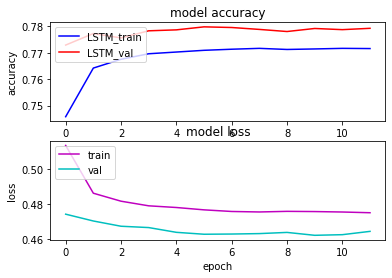

In [ ]:
# Visualize the accuracy and loss of the model trhough the training

s, (at, al) = plt.subplots(2,1)
at.plot(history.history['accuracy'], c= 'b')
at.plot(history.history['val_accuracy'], c='r')
at.set_title('model accuracy')
at.set_ylabel('accuracy')
at.set_xlabel('epoch')
at.legend(['LSTM_train', 'LSTM_val'], loc='upper left')

al.plot(history.history['loss'], c='m')
al.plot(history.history['val_loss'], c='c')
al.set_title('model loss')
al.set_ylabel('loss')
al.set_xlabel('epoch')
al.legend(['train', 'val'], loc = 'upper left')

In [ ]:
# the results of sigmoid: <0.5 is Negative and >0.5 Positive
def decode_sentiment(score):
    return "Positive" if score>0.5 else "Negative"


scores = model.predict(x_test, verbose=1, batch_size=10000)
y_pred_1d = [decode_sentiment(score) for score in scores]

32/32 [==============================] - 7s 209ms/step


In [ ]:
import itertools
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# Configurations for the confusion matrix
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=20)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=13)
    plt.yticks(tick_marks, classes, fontsize=13)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=17)
    plt.xlabel('Predicted label', fontsize=17)

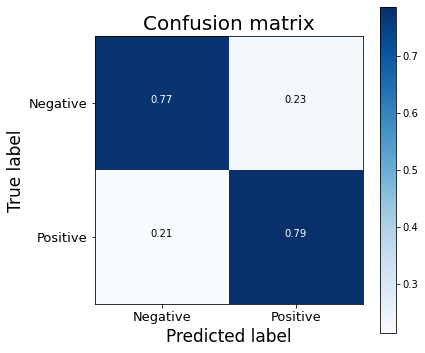

In [ ]:
# Graph confusion matrix
cnf_matrix = confusion_matrix(test_data.sentiment.to_list(), y_pred_1d)
plt.figure(figsize=(6,6))
plot_confusion_matrix(cnf_matrix, classes=test_data.sentiment.unique(), title="Confusion matrix")
plt.show()

In [ ]:
print(classification_report(list(test_data.sentiment), y_pred_1d))

              precision    recall  f1-score   support

    Negative       0.78      0.77      0.78    159815
    Positive       0.78      0.79      0.78    160185

    accuracy                           0.78    320000
   macro avg       0.78      0.78      0.78    320000
weighted avg       0.78      0.78      0.78    320000



## To know More

CNN and LSTM
https://arxiv.org/pdf/1511.08630.pdf

BB_twtr model
https://arxiv.org/pdf/1704.06125v1.pdf

Extra information
https://www.researchgate.net/publication/341873850_Text_based_Sentiment_Analysis_using_LSTM

https://stackabuse.com/python-for-nlp-movie-sentiment-analysis-using-deep-learning-in-keras/
